# Estrategia para la localización Óptima de Sensores de Contaminación Lumínica

In [1]:
from PIL import Image
import numpy as np
from noisyopt import minimizeCompass
from sortedcontainers import SortedList
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
from matplotlib.pylab import rcParams
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import cm
import matplotlib.patches as mpatches

In [2]:
def f5(i,p,e=4):
    '''
    Pesos exponenciales
    
    W = i*a^(p-r)
    '''
    return i*e**(p)

def getN(W,i,j):
    ln = ([])
    c = W[i,j]
    ln.append(W[i+1,j])
    ln.append(W[i-1,j])
    ln.append(W[i,j+1])
    ln.append(W[i,j-1])
    opt = False if W[i,j]<max(ln) else True
    return opt

def fuerza_puntual(x,y,im2,h=2,e=2):
    '''
    this does not make sense if we have corrected verions solving the saturarion image problem
    
    '''
    s = 0.0 
    g1 = float(im2[x][y])
    xlb = 0 if(x-h)<0 else x-h
    xub = im2.shape[0] if(x+h)> im2.shape[0] else x+h
    
    ylb = 0 if(y-h)<0 else y-h
    yub = im2.shape[1] if(y+h)> (im2.shape[1]) else y+h 
    
    ri = np.arange(xlb,xub)
    rj = np.arange(ylb,yub)
    for i in ri:
        for j in rj:
            d=((i-x)**2+(j-y)**2)**(0.5)
            g2 = float(im2[i][j])
            if d >0: s += (g1*g2)/(d**e)
    return s

def filtro_fuerza_puntual(A,h=3,e=2):
    pot1 = np.zeros(A.shape)
    for i in range(pot1.shape[0]):
        for j in range(pot1.shape[1]):
            pot1[i][j] = fuerza_puntual(i,j,A,h,e)
            
    return pot1


def plot_examples(data,colormaps,filename):
    """
    Helper function to plot data with associated colormap.
    """
    n = len(colormaps)
    #fig, axs = plt.subplots(1, n, figsize=(n * 2 + 2, 3),
    #                        constrained_layout=False, squeeze=False)
    fig, axs = plt.subplots(1, n, figsize=(6, 5.2),constrained_layout=False, squeeze=False)
   
    scalebar = ScaleBar(1000) # 1 pixel = 0.2 meter
    plt.gca().add_artist(scalebar)
    for [ax, cmap] in zip(axs.flat, colormaps):
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        psm = ax.pcolormesh(np.flip(data,0), cmap=cmap, rasterized=False, vmin=0, vmax=data.max())
        fig.colorbar(psm, ax=ax)
    
    

    plt.savefig(filename, dpi = 150)

custom_cmap = cm.get_cmap('hot', 256)
newcolors = custom_cmap(np.linspace(0, 1, 256))
pink = np.array([200/256, 200/256, 200/256, 1])
newcolors[:1, :] = pink
newcmp = ListedColormap(newcolors)

Carga de imágenes

In [3]:
#Original nocturnal image without values <21
im1 = np.array(Image.open('inputs/qro_light_th'))
im1 = np.where(im1==255, 0, im1) 

#Region priorities of Jorge and Lamphar
P = np.array(Image.open('inputs/prioridades'))

#calcular este valor automaticamente
nc = 5

# 0 máxima prioridad
# 4 mínima prioridad (antes espacio nan)
P = np.where(np.isnan(P),nc, P)-1 
P = P.max()-P


im1_gr = filtro_fuerza_puntual(im1,h=3,e=4)

W1 = f5(im1,P)
W2 = f5(im1_gr,P)

In [4]:
np.max(im1.flatten())

63

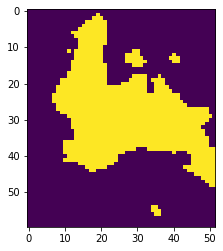

In [5]:
plt.imshow((im1>=10) )

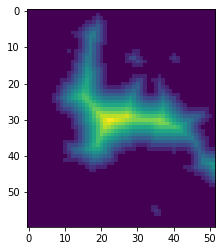

In [6]:
from scipy import ndimage as ndi
d = ndi.distance_transform_edt(im1>=1)

plt.imshow(d)

W3 = f5(d,P)


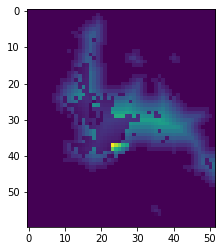

In [7]:
plt.imshow(W3)

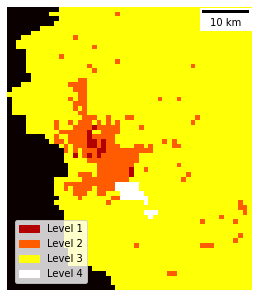

In [8]:
data = P

# get the unique values from data
# i.e. a sorted list of all values in data
values = np.unique(data.ravel())

plt.figure(figsize=(6, 5.2))
im = plt.imshow(data,cmap = plt.cm.hot)

# get the colors of the values, according to the 
# colormap used by imshow
colors = [ im.cmap(im.norm(value)) for value in values]
# create a patch (proxy artist) for every color 
patches = [ mpatches.Patch(color=colors[i], label="Level {l}".format(l=int(values[i])) ) for i in range(1,5) ]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(0.33, 0.25), loc=1, borderaxespad=0.1 )
plt.axis('off')
scalebar = ScaleBar(1000) # 1 pixel = 0.2 meter
plt.gca().add_artist(scalebar)

plt.savefig("figures/01_importance_level_map.pdf", dpi = 150)

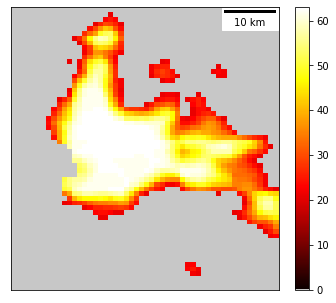

In [9]:
custom_cmap = cm.get_cmap('hot', 256)
newcolors = custom_cmap(np.linspace(0, 1, 256))
pink = np.array([200/256, 200/256, 200/256, 1])
newcolors[:1, :] = pink
newcmp = ListedColormap(newcolors)
plot_examples(im1,[newcmp],"figures/02_original_nighttime.pdf")


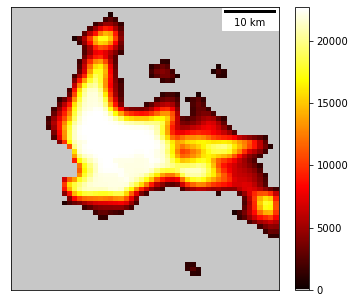

In [10]:

plot_examples(im1_gr,[newcmp],"figures/03_gravitational_nighttime_map.pdf")


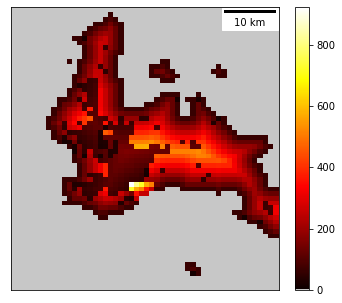

In [11]:
plot_examples(W3,[newcmp],"figures/04_priority_levels.pdf")



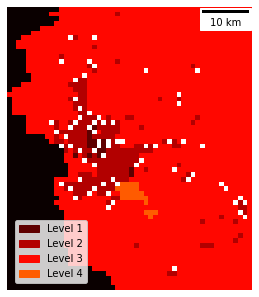

In [25]:
B = np.zeros(im1_gr.shape)
for i in range(1,im1_gr.shape[0]-1):
    for j in range(1,im1_gr.shape[1]-1):

        B[i][j] = getN(W2,i,j)
        
positionsB = B*(im1>0)

locationsP = np.zeros(P.shape)
for i in range(0,P.shape[0]):
    for j in range(0,P.shape[1]):
        locationsP[i][j] = 8 if positionsB[i][j]==1 else P[i,j]

data = locationsP

# get the unique values from data
# i.e. a sorted list of all values in data
values = np.unique(data.ravel())

plt.figure(figsize=(6, 5.2))
im = plt.imshow(data,cmap = plt.cm.hot)

# get the colors of the values, according to the 
# colormap used by imshow
colors = [ im.cmap(im.norm(value)) for value in values]

# create a patch (proxy artist) for every color 
patches = [ mpatches.Patch(color=colors[i], label="Level {l}".format(l=int(values[i])) ) for i in range(1,5) ]

# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(0.33, 0.25), loc=1, borderaxespad=0.1 )
plt.axis('off')
scalebar = ScaleBar(1000) # 1 pixel = 0.2 meter
plt.gca().add_artist(scalebar)

plt.savefig("figures/05_positions_and_importance.pdf", dpi = 150)

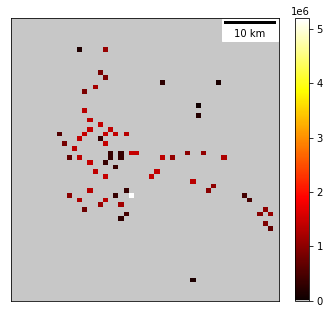

In [16]:
custom_cmap = cm.get_cmap('hot', 256)
newcolors = custom_cmap(np.linspace(0, 1, 256))
fire = np.array([200/256, 200/256, 200/256, 1])
newcolors[:1, :] = fire
newcmp = ListedColormap(newcolors)
plot_examples(W2*positionsB,[newcmp],"figures/06_positions_with_priority.pdf")

In [30]:
A = W2*positionsB
A[0][0]
plt.imshow(W2*positionsB)

0.0

In [174]:
p=0.8

L = list()


for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        if A[i][j] > 0: L.append([A[i][j],i,j]) 

L.sort()
posList = L





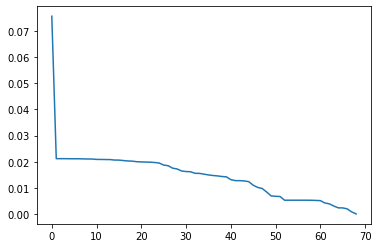

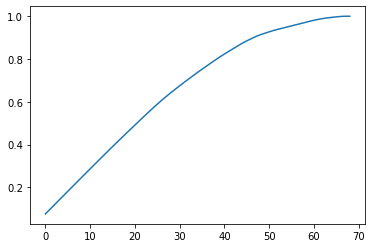

In [163]:

L = np.array(L)
sL = np.sum(L[:,0])


sortedSensors =  np.flip(np.sort(L[:,0]/sL))
plt.plot((sortedSensors) )

plt.show()

cumsumSortedSensors = np.cumsum(sortedSensors)
plt.plot( cumsumSortedSensors )
plt.show()

In [ ]:
L.reverse()

array([7.56134264e-02, 2.11690557e-02, 2.11690557e-02, 2.11683610e-02,
       2.11411652e-02, 2.11352298e-02, 2.11333804e-02, 2.10873656e-02,
       2.10508987e-02, 2.10326176e-02, 2.08874019e-02, 2.08707667e-02,
       2.08400970e-02, 2.08231019e-02, 2.06404005e-02, 2.06216355e-02,
       2.04511541e-02, 2.02898804e-02, 2.02225169e-02, 1.99983279e-02,
       1.99277518e-02, 1.98771451e-02, 1.98313981e-02, 1.97015718e-02,
       1.95071652e-02, 1.87141158e-02, 1.84803760e-02, 1.75395919e-02,
       1.72358219e-02, 1.64579490e-02, 1.62433492e-02, 1.61753900e-02,
       1.55699968e-02, 1.55471794e-02, 1.52545311e-02, 1.49515165e-02,
       1.47414083e-02, 1.45873922e-02, 1.43476424e-02, 1.42236906e-02,
       1.31510239e-02, 1.27776283e-02, 1.27656835e-02, 1.26646447e-02,
       1.23864999e-02, 1.10235114e-02, 1.01709284e-02, 9.77858540e-03,
       8.42897918e-03, 6.93574210e-03, 6.78886224e-03, 6.69958103e-03,
       5.29226393e-03, 5.29226393e-03, 5.29226393e-03, 5.29226393e-03,
      

sensor: 1


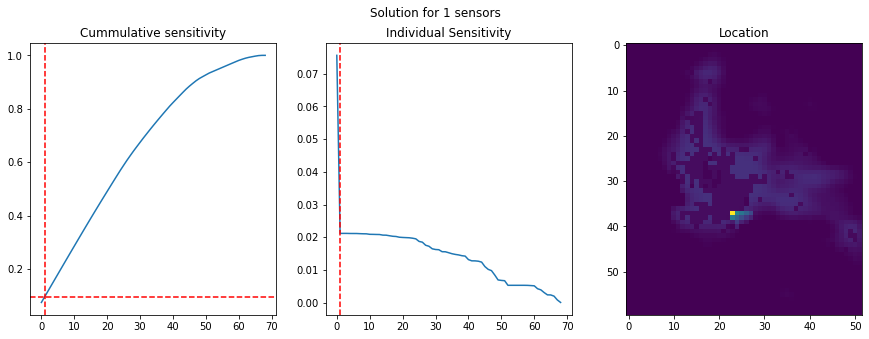

sensor: 2


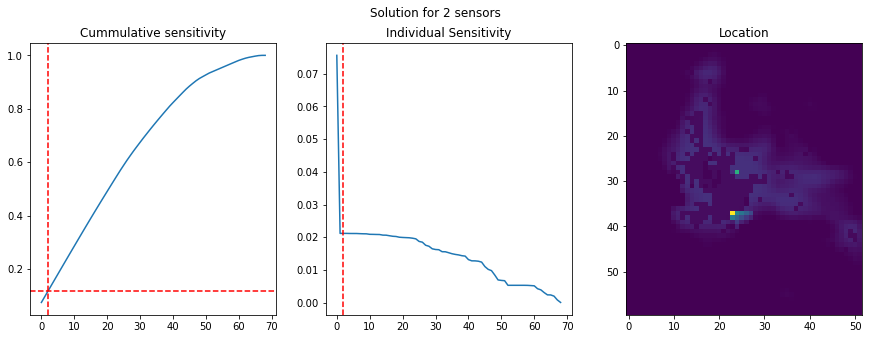

sensor: 3


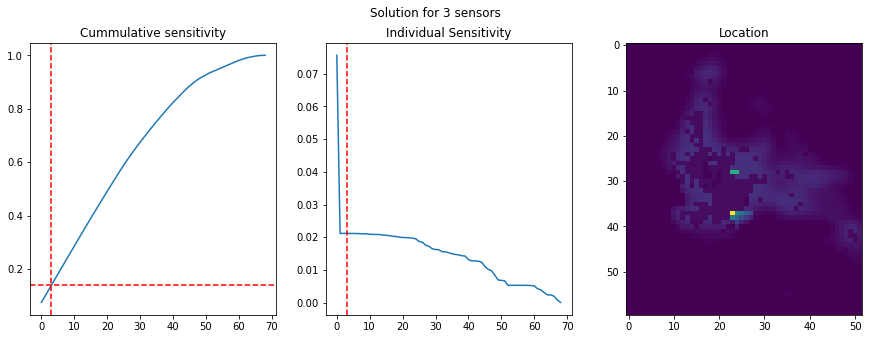

sensor: 4


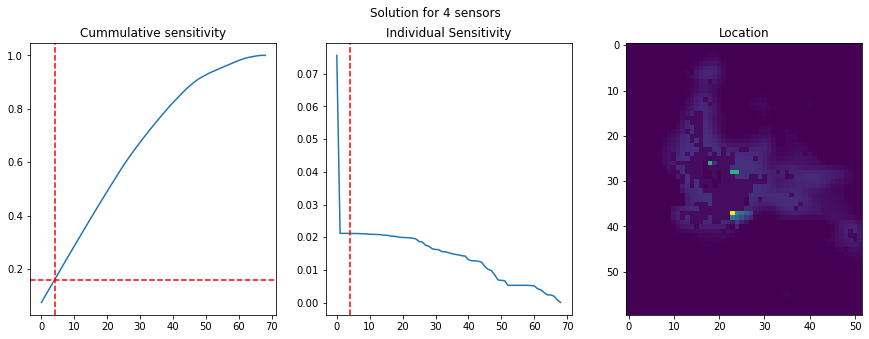

sensor: 5


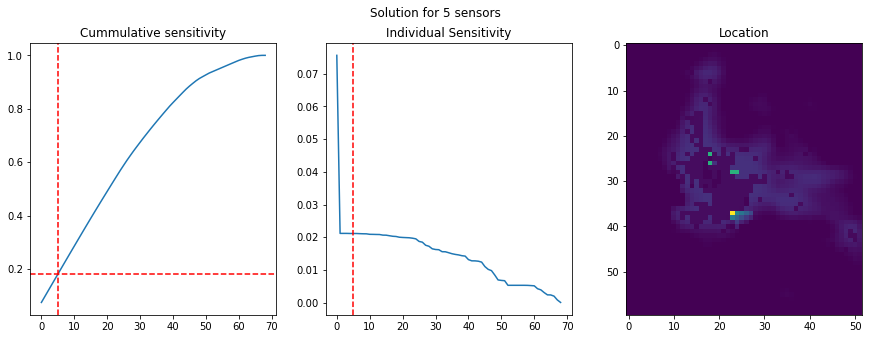

sensor: 6


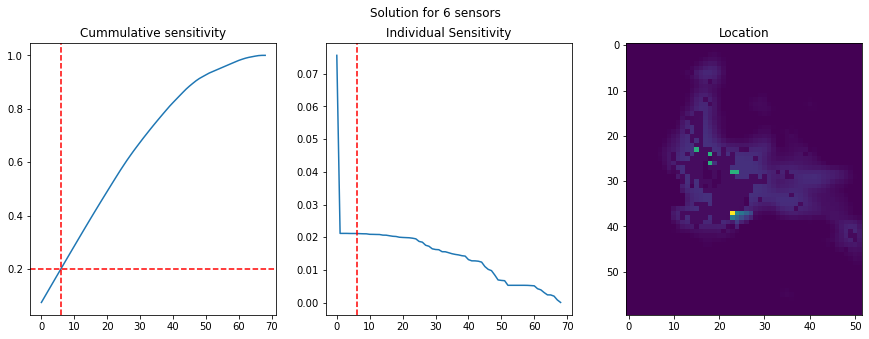

sensor: 7


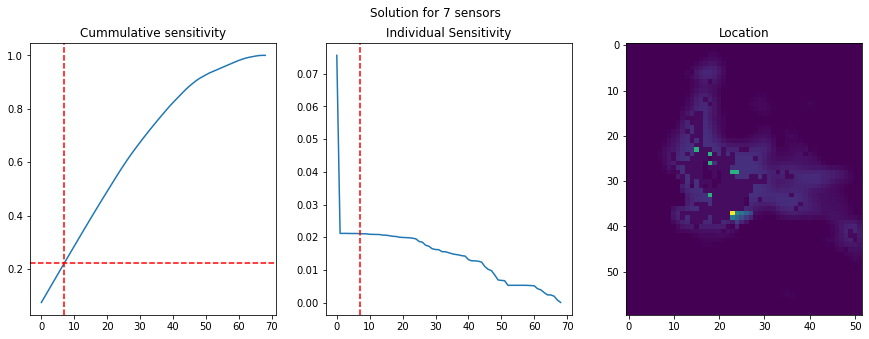

sensor: 8


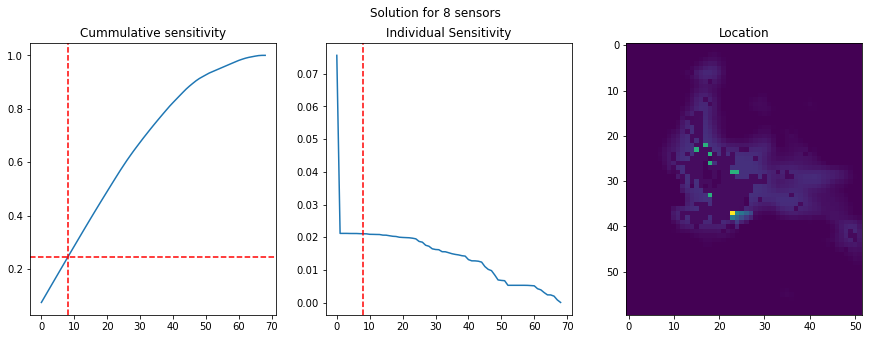

sensor: 9


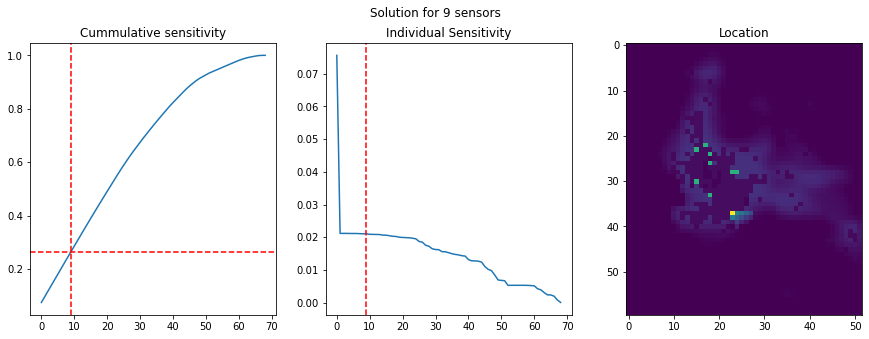

sensor: 10


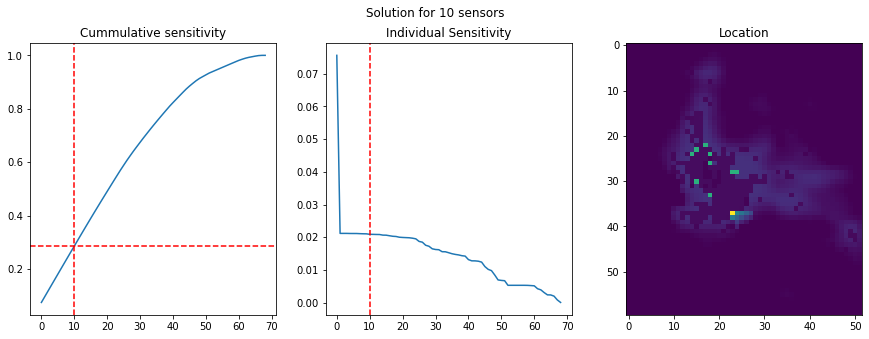

sensor: 11


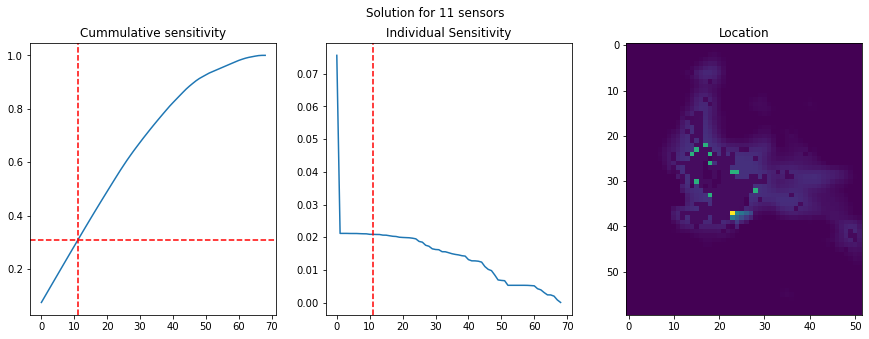

sensor: 12


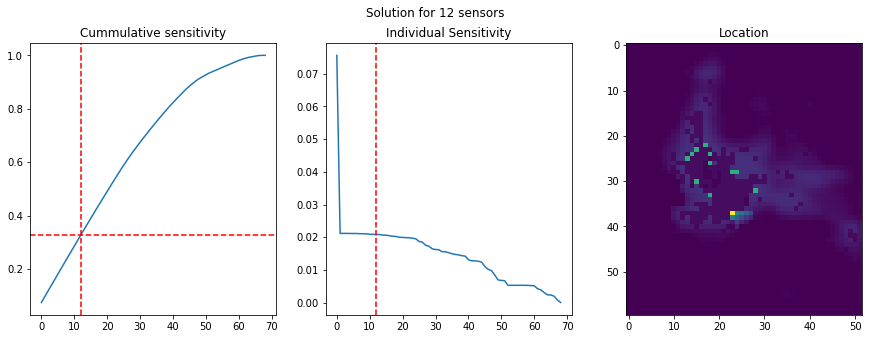

sensor: 13


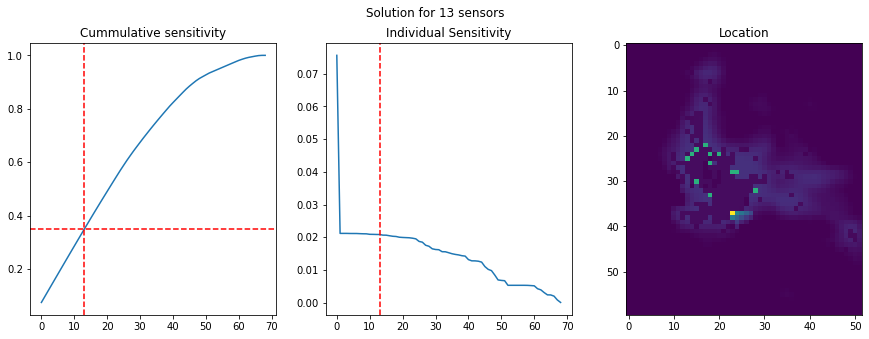

sensor: 14


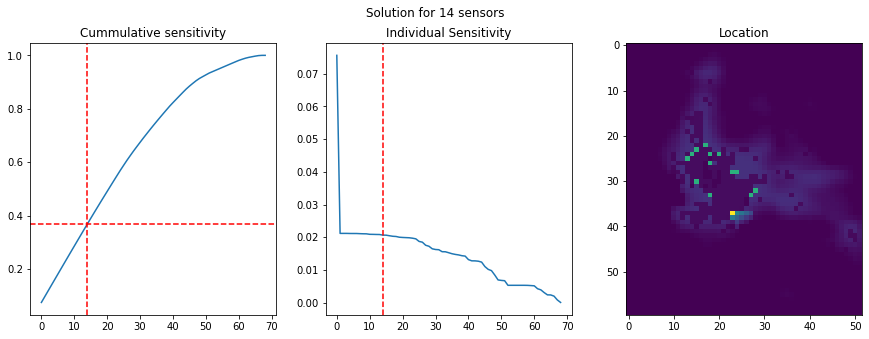

sensor: 15


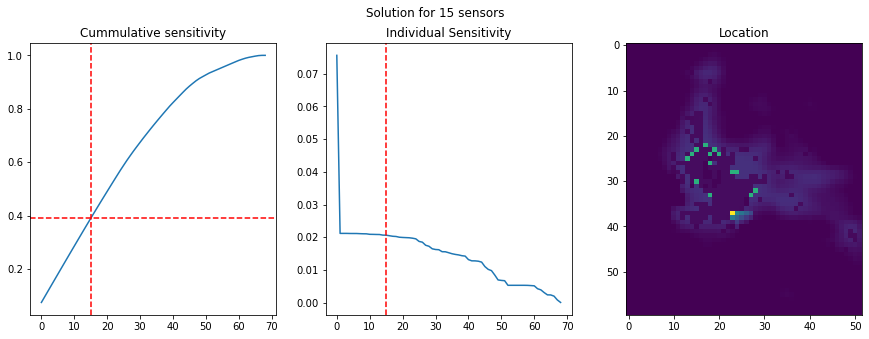

sensor: 16


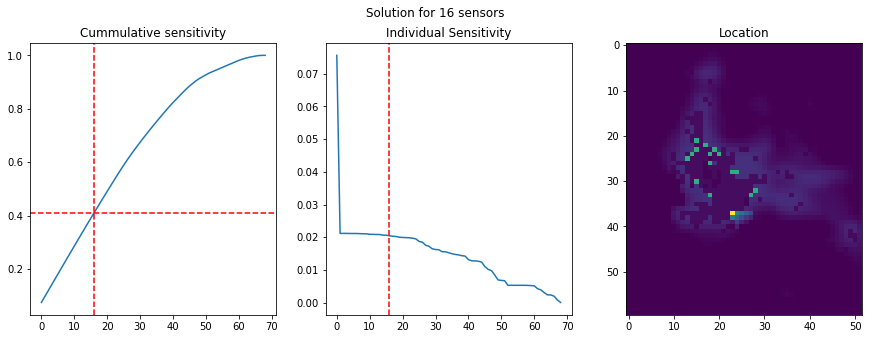

sensor: 17


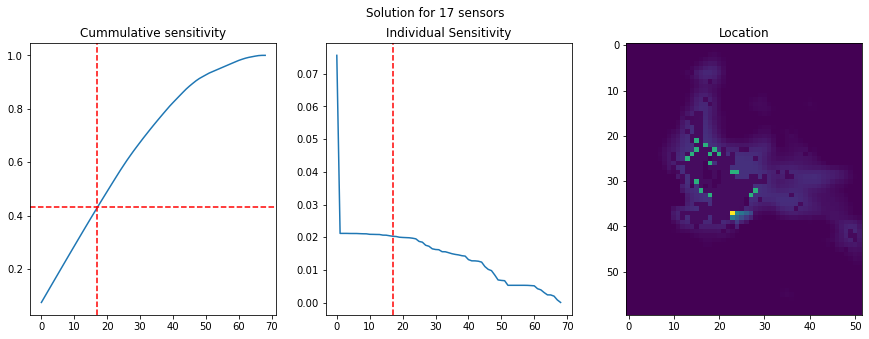

sensor: 18


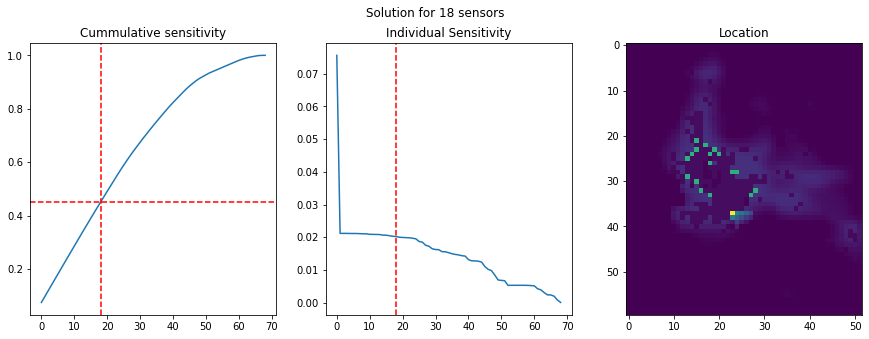

sensor: 19


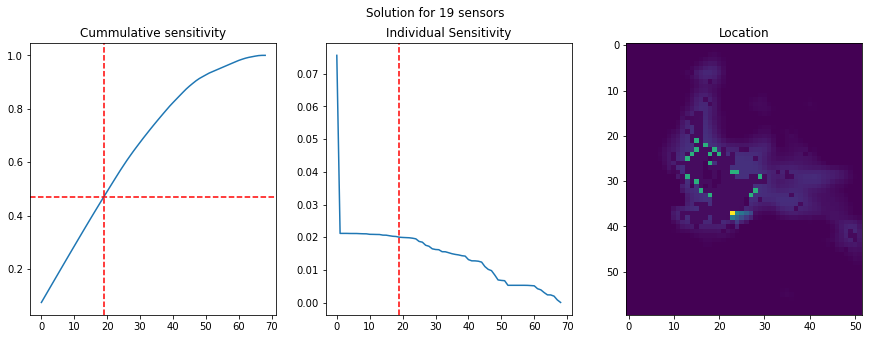

sensor: 20


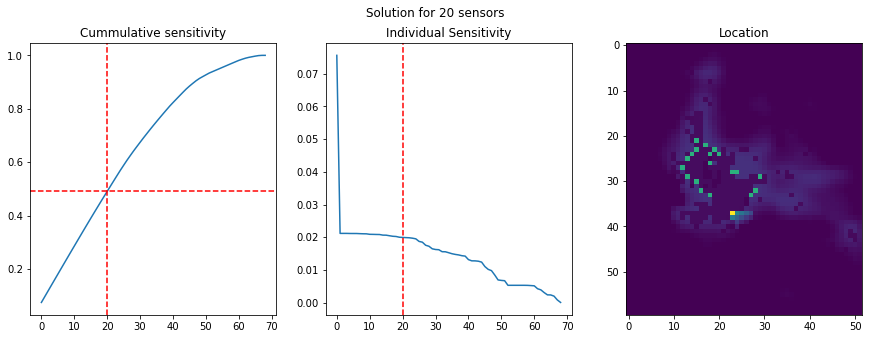

sensor: 21


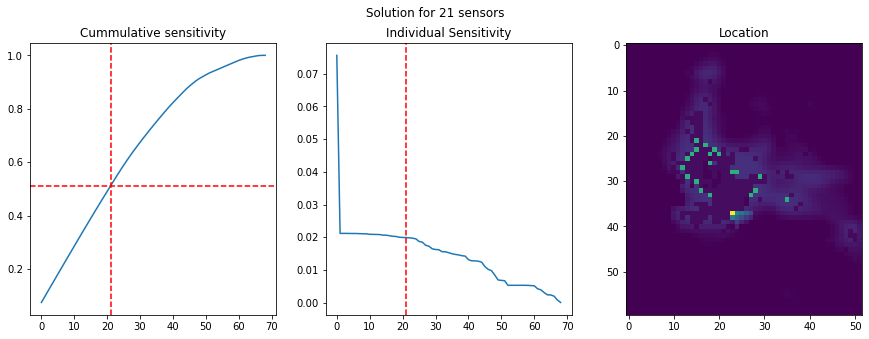

sensor: 22


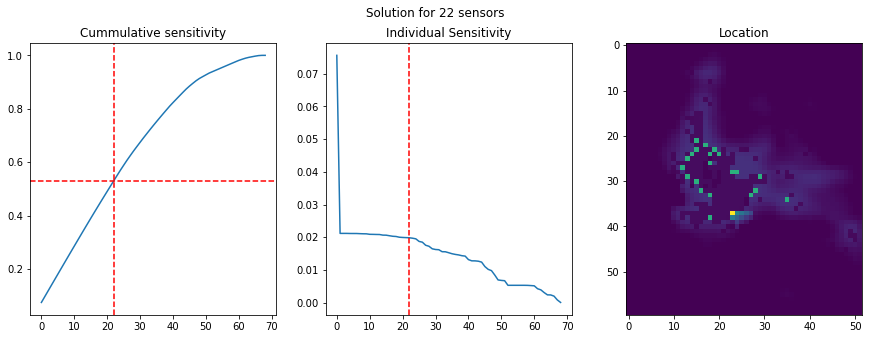

sensor: 23


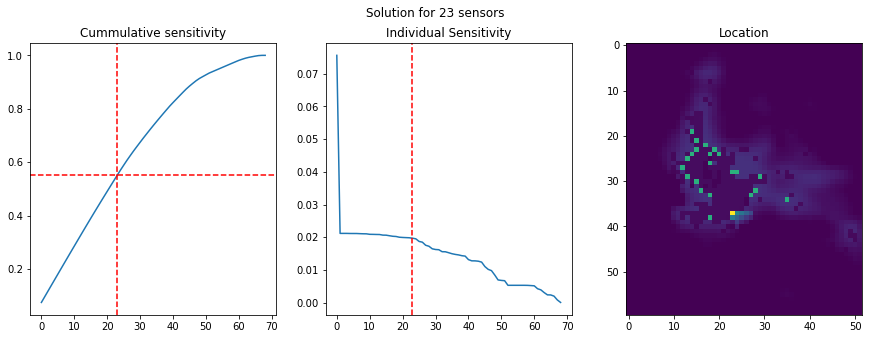

sensor: 24


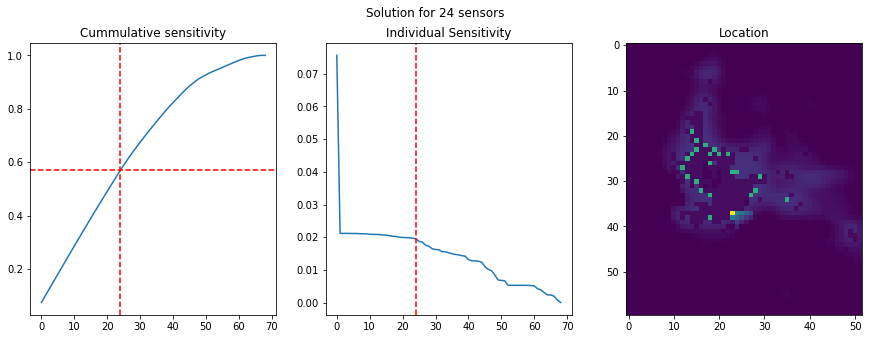

sensor: 25


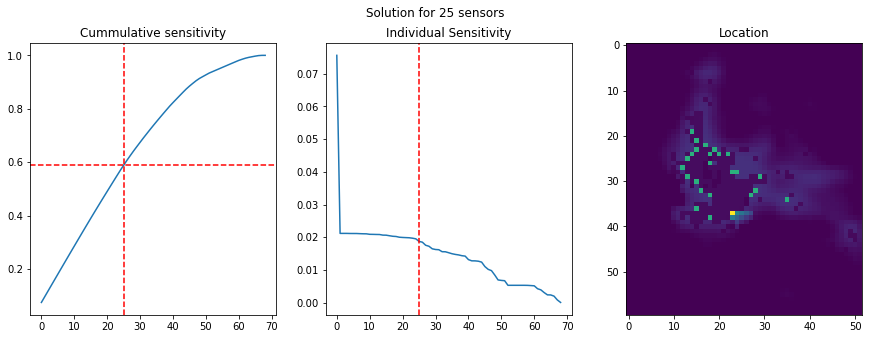

sensor: 26


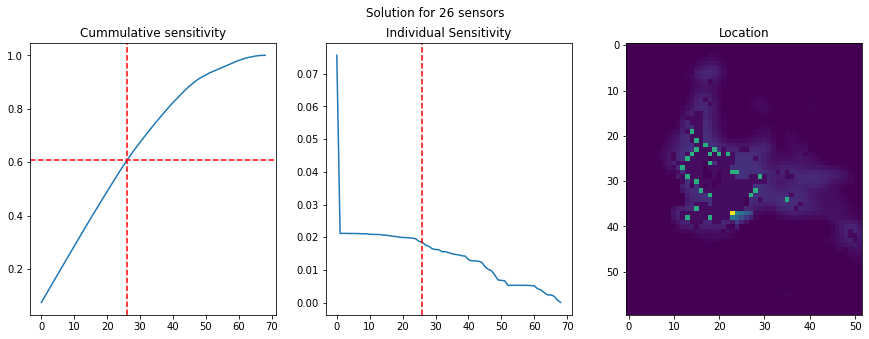

sensor: 27


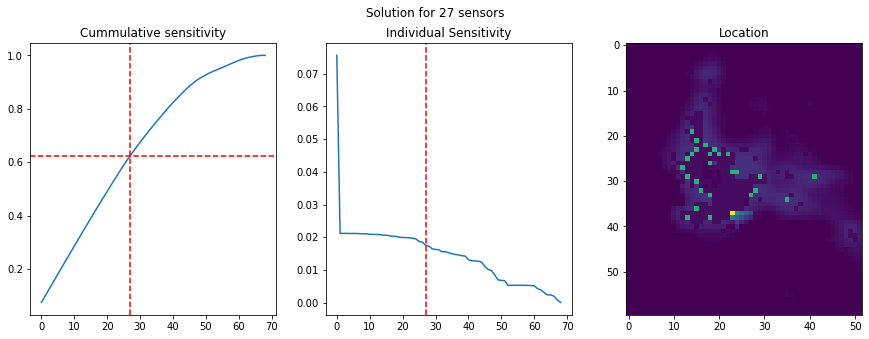

sensor: 28


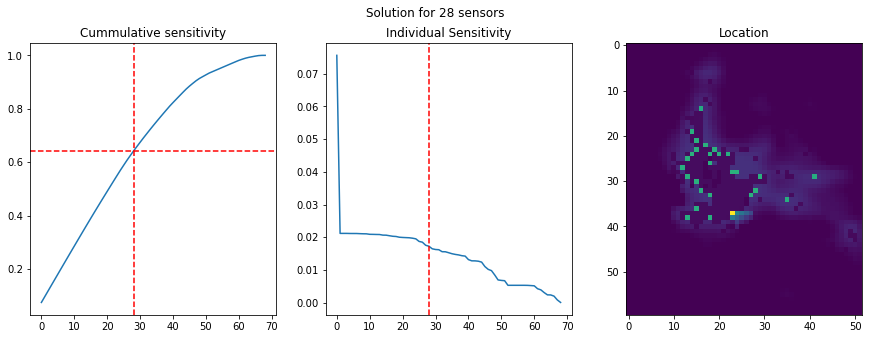

sensor: 29


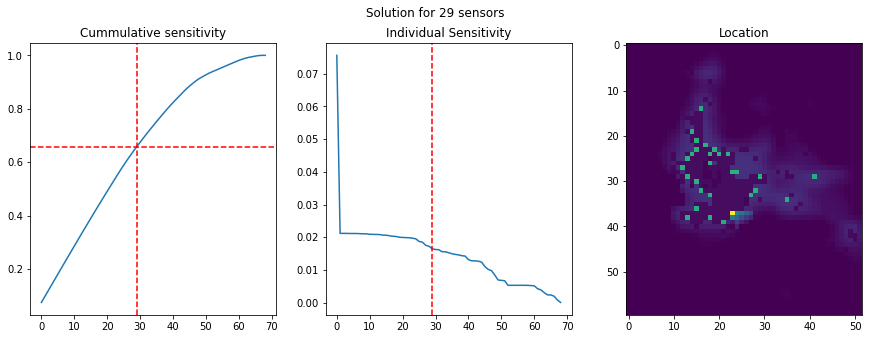

sensor: 30


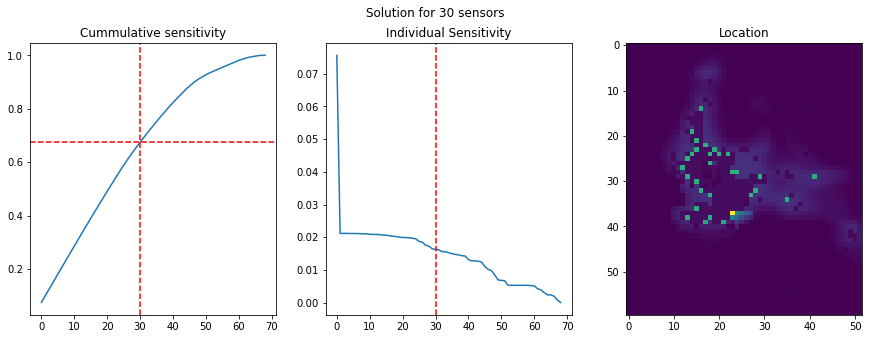

sensor: 31


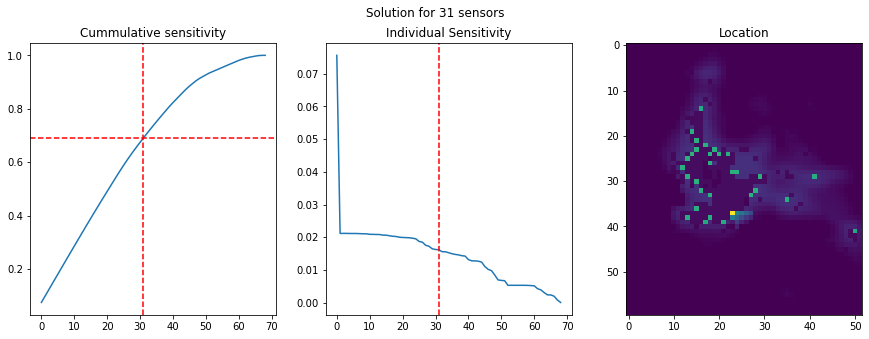

sensor: 32


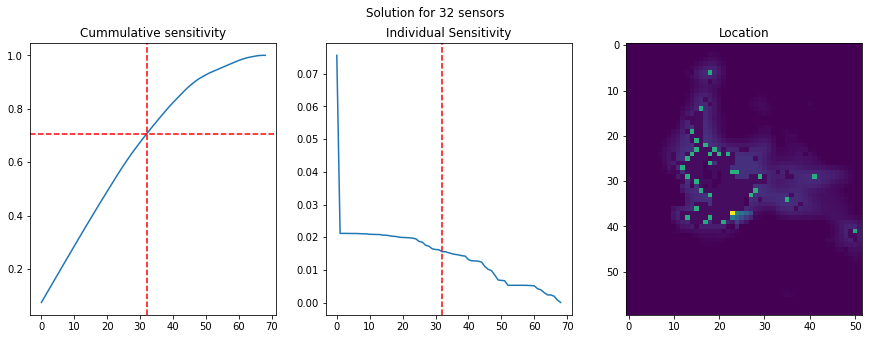

sensor: 33


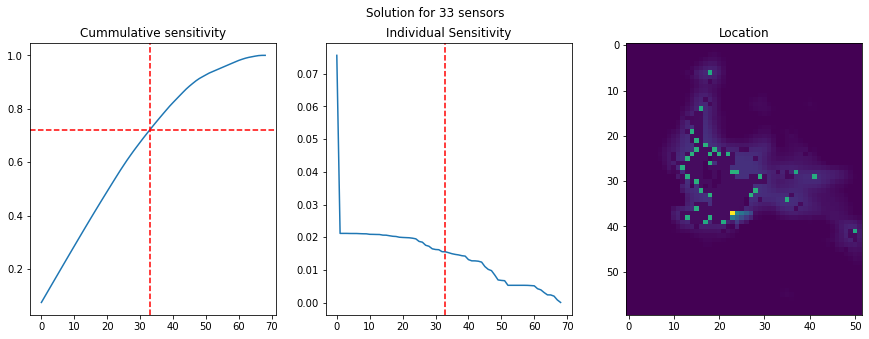

sensor: 34


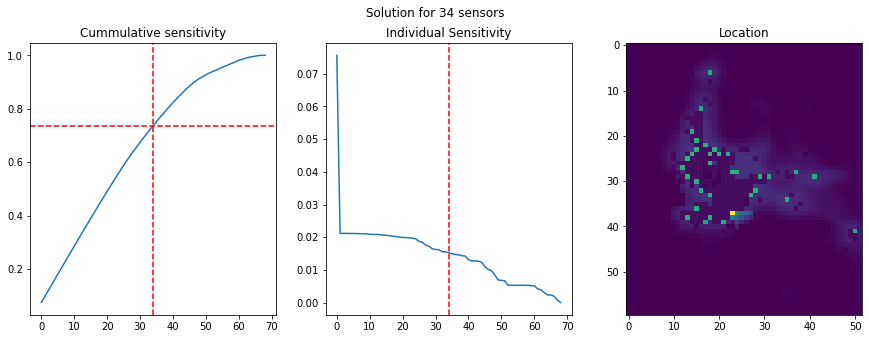

sensor: 35


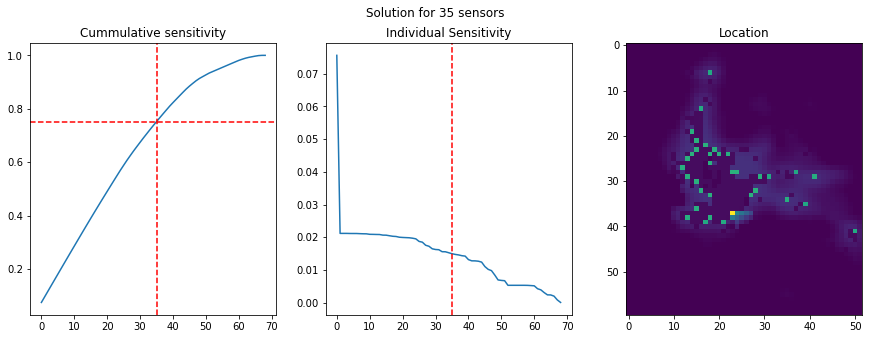

sensor: 36


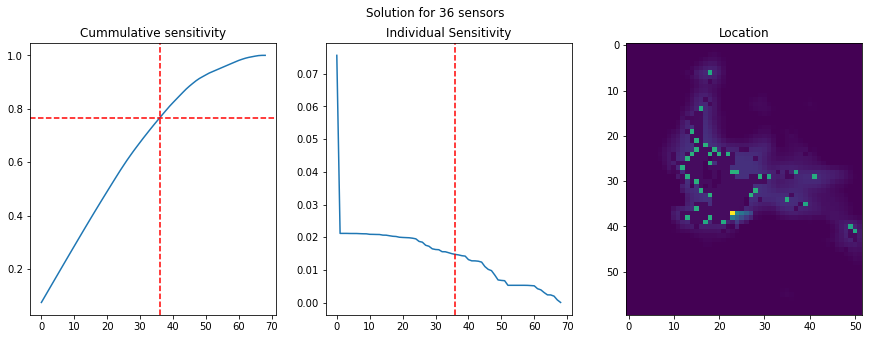

sensor: 37


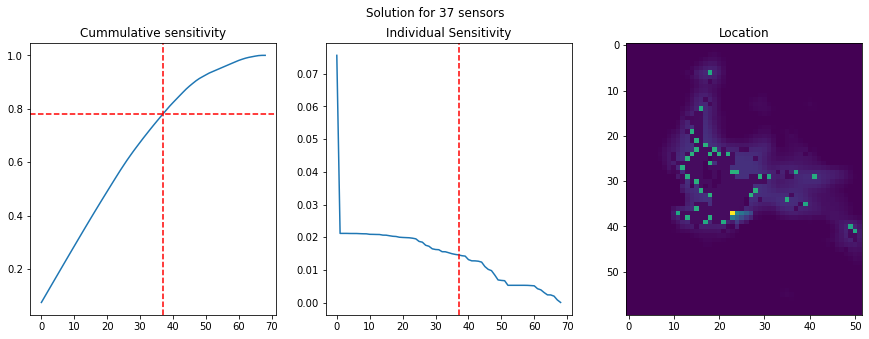

sensor: 38


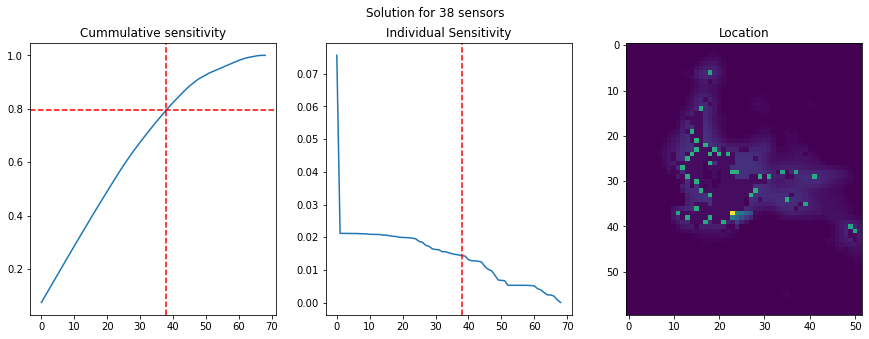

sensor: 39


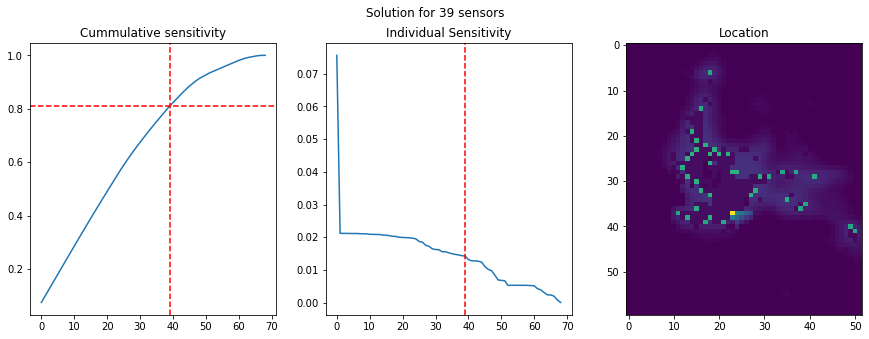

sensor: 40


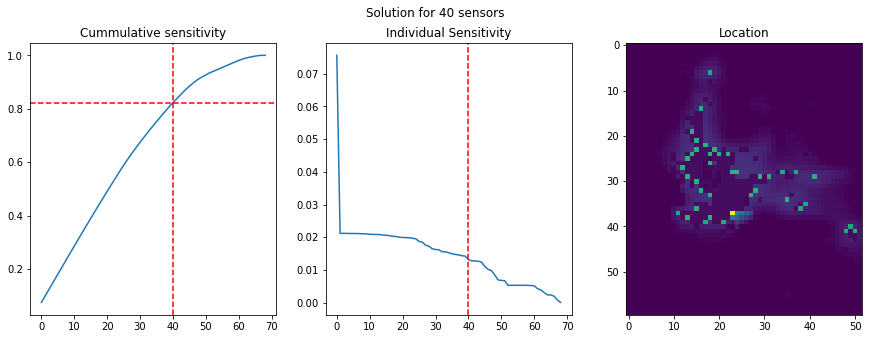

sensor: 41


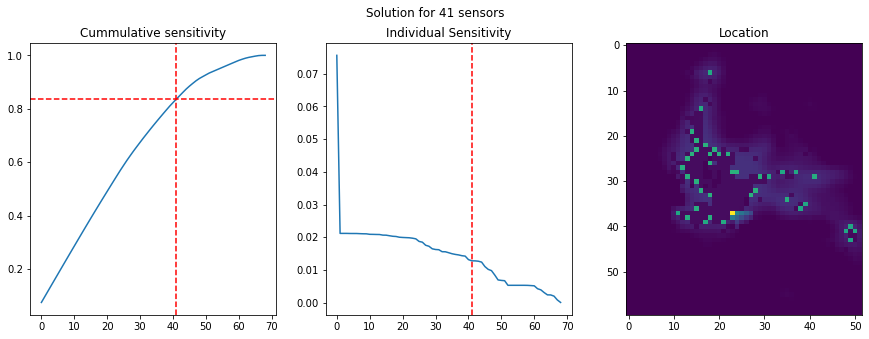

sensor: 42


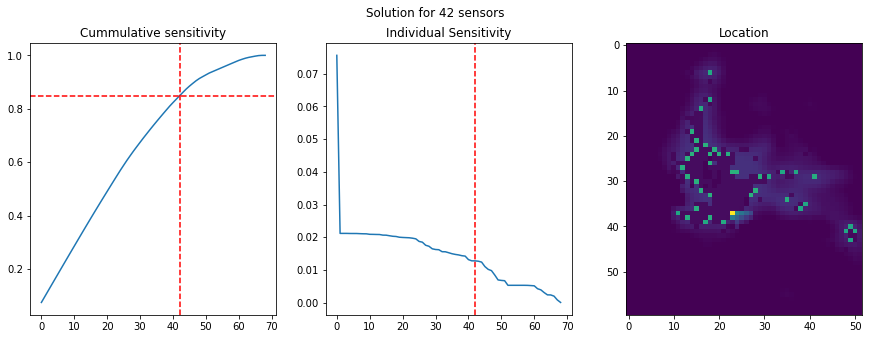

sensor: 43


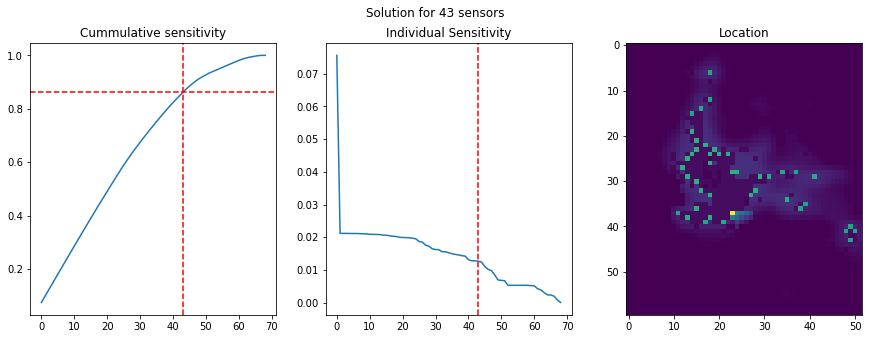

sensor: 44


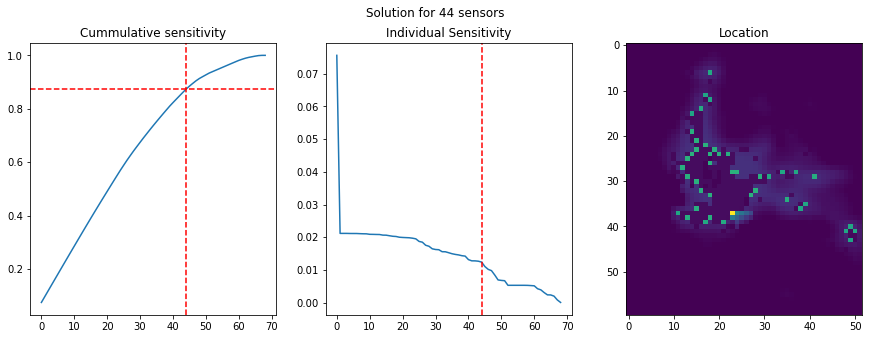

sensor: 45


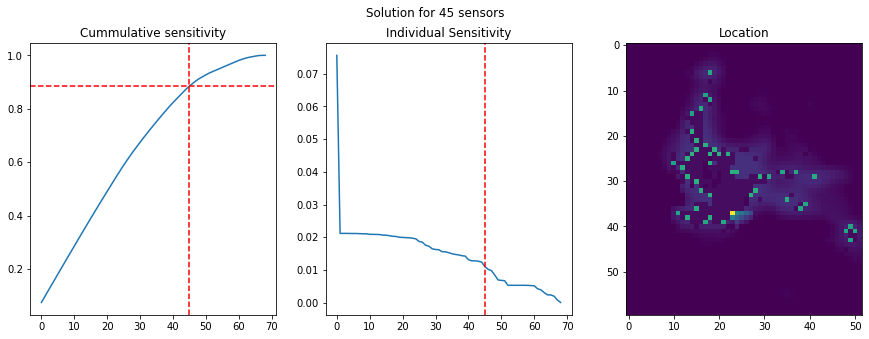

sensor: 46


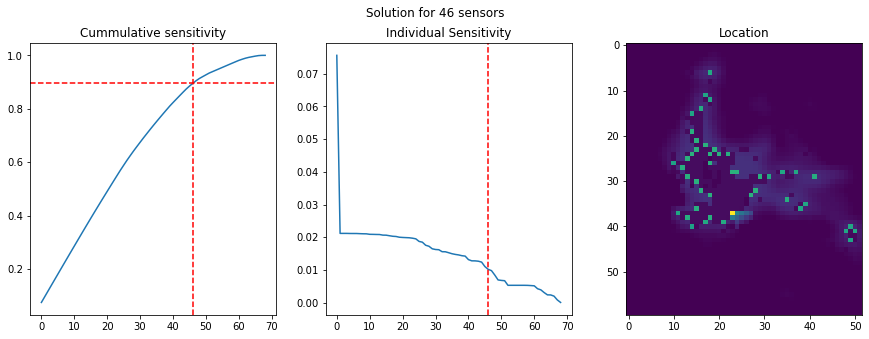

sensor: 47


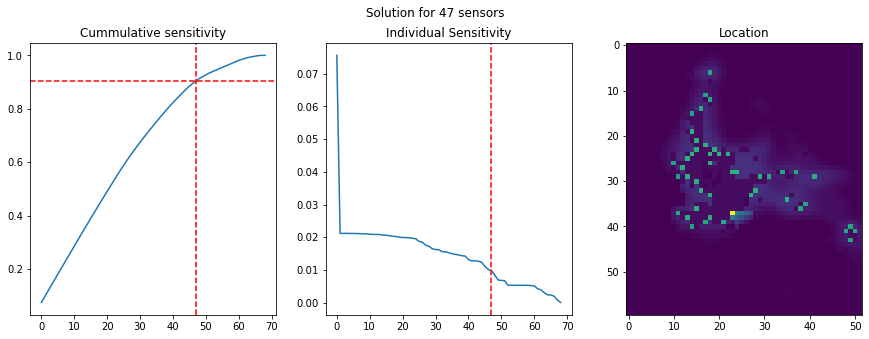

sensor: 48


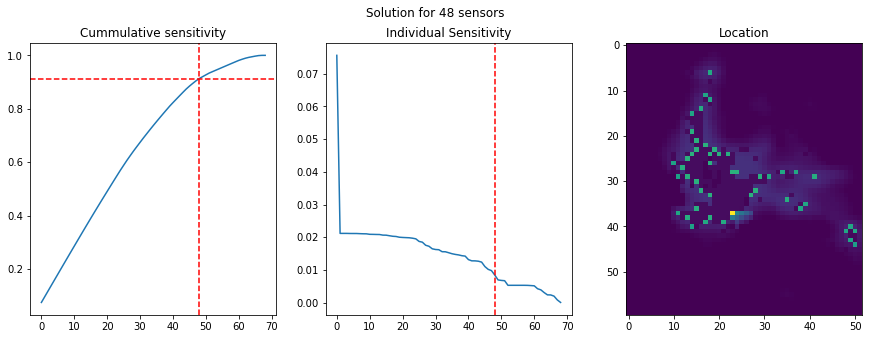

sensor: 49


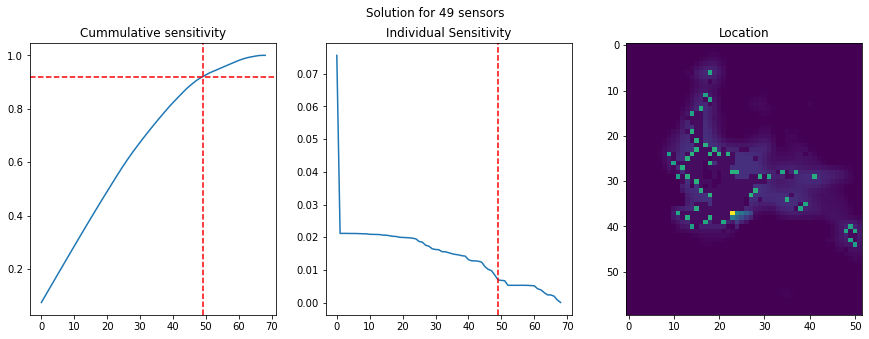

sensor: 50


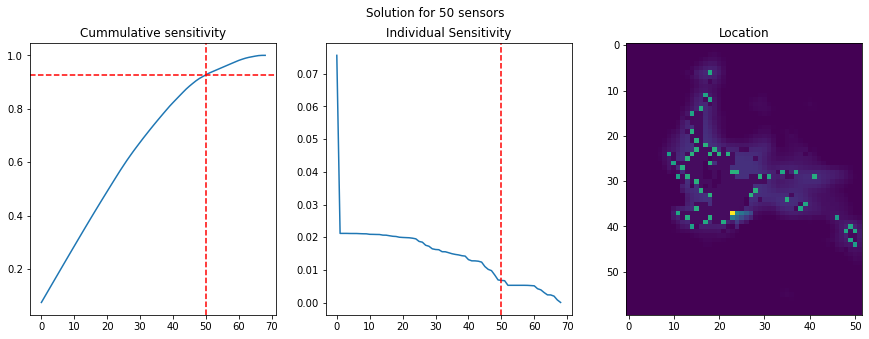

sensor: 51


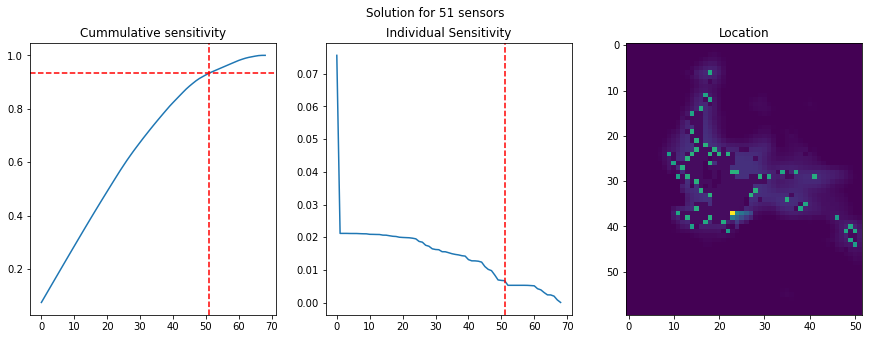

sensor: 52


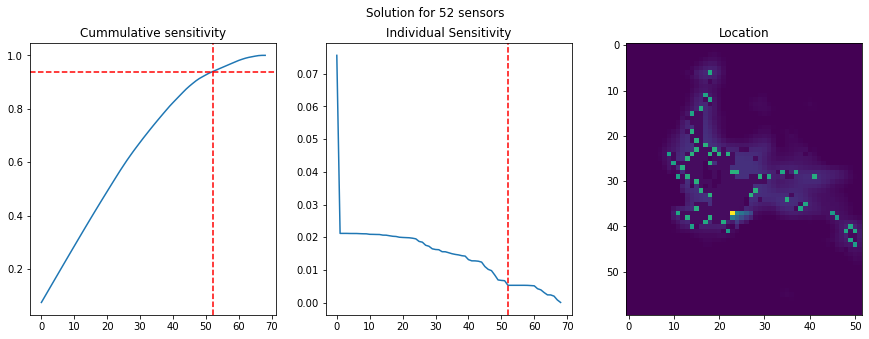

sensor: 53


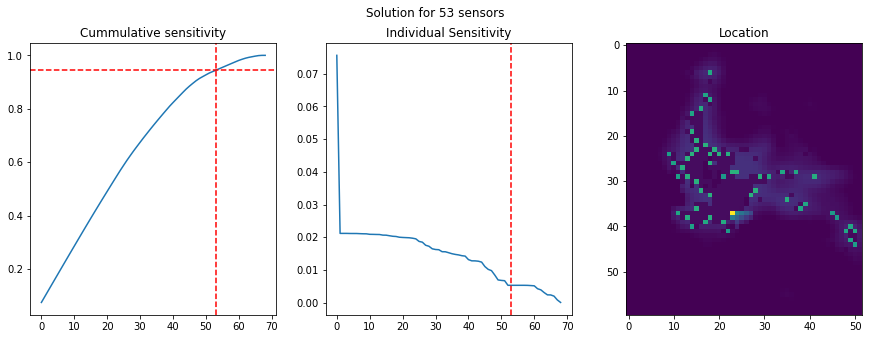

sensor: 54


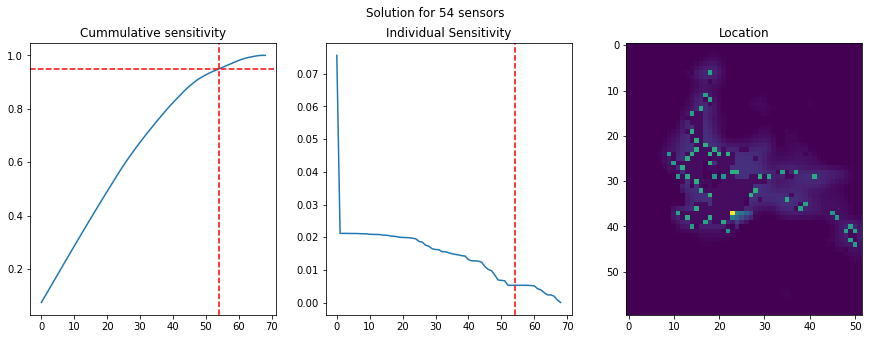

sensor: 55


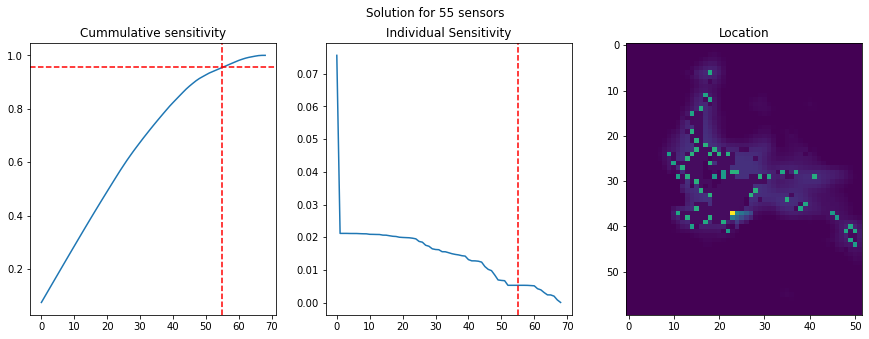

sensor: 56


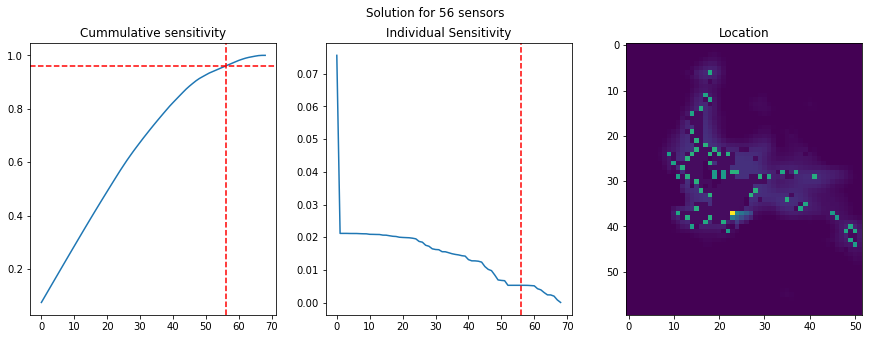

sensor: 57


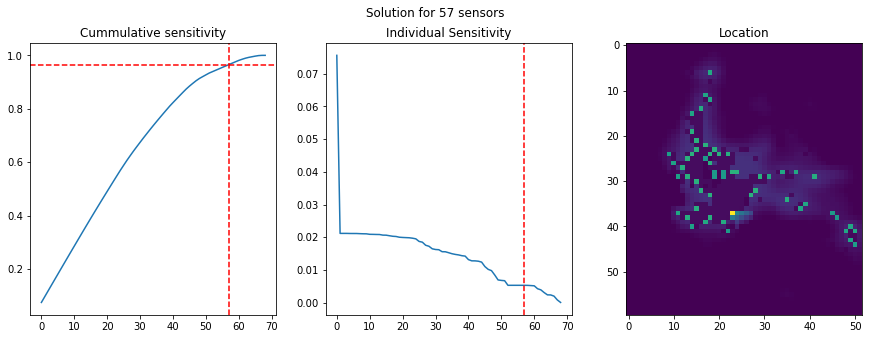

sensor: 58


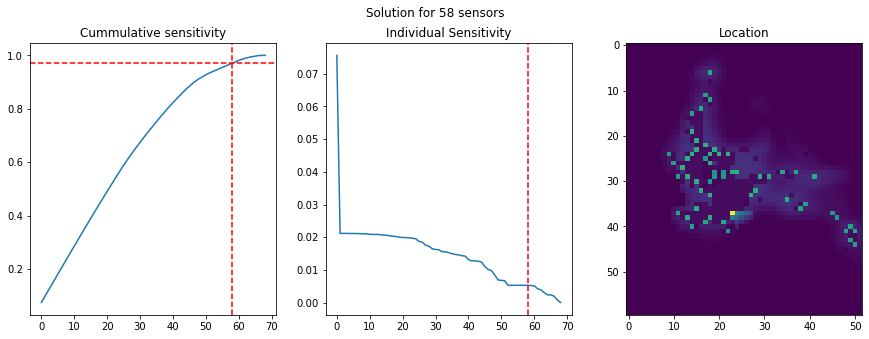

sensor: 59


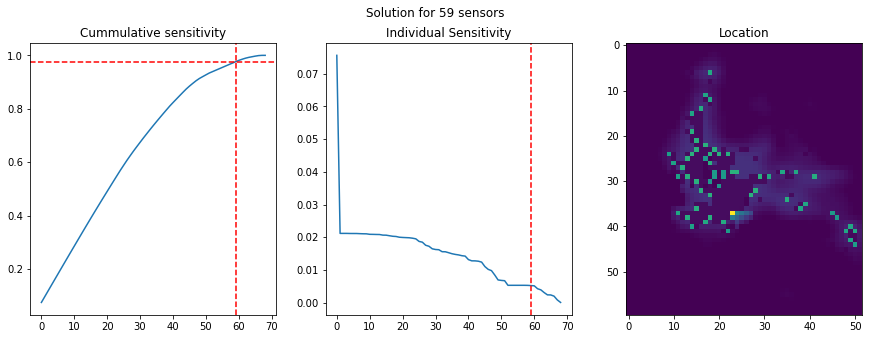

sensor: 60


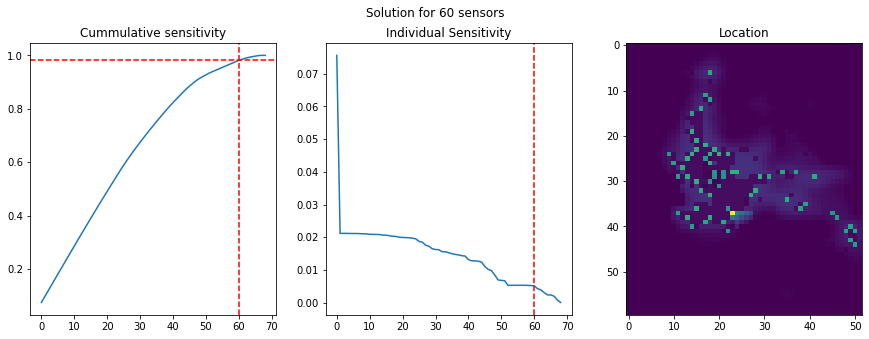

sensor: 61


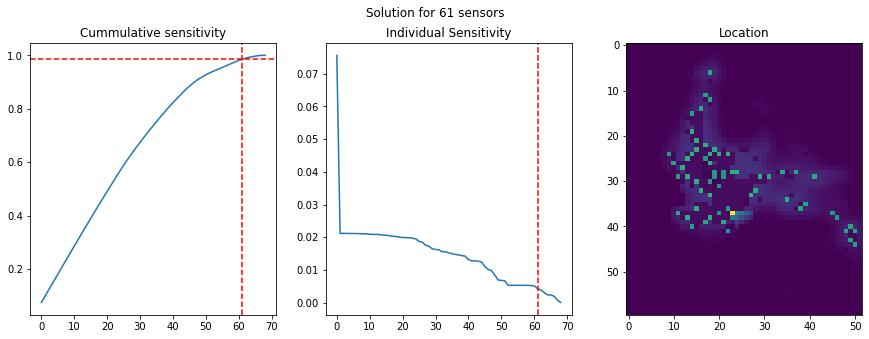

sensor: 62


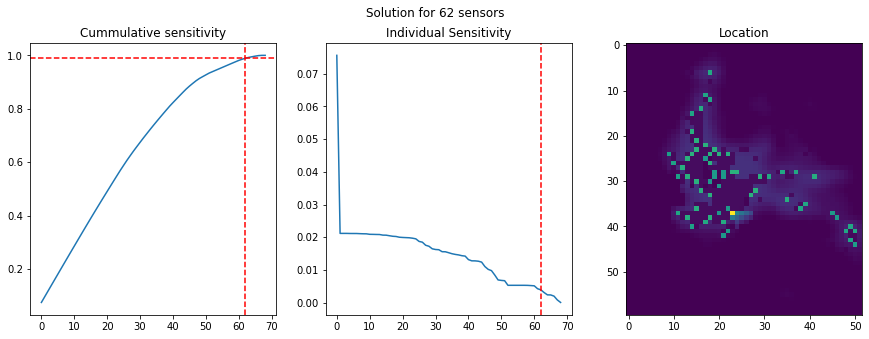

sensor: 63


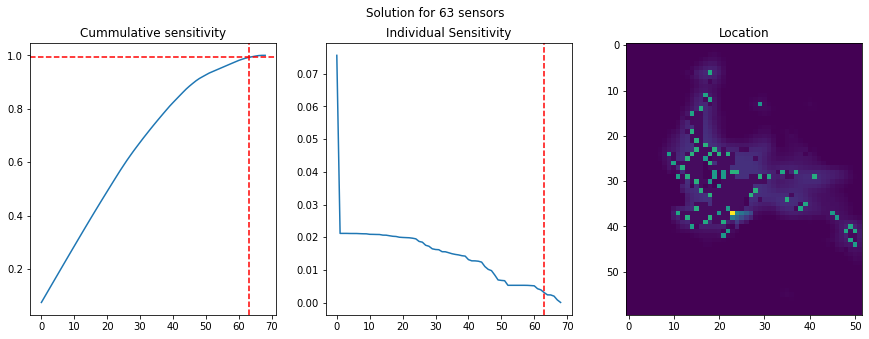

sensor: 64


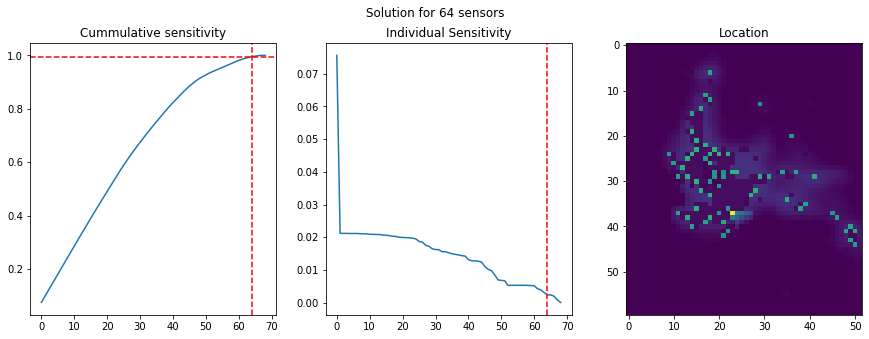

sensor: 65


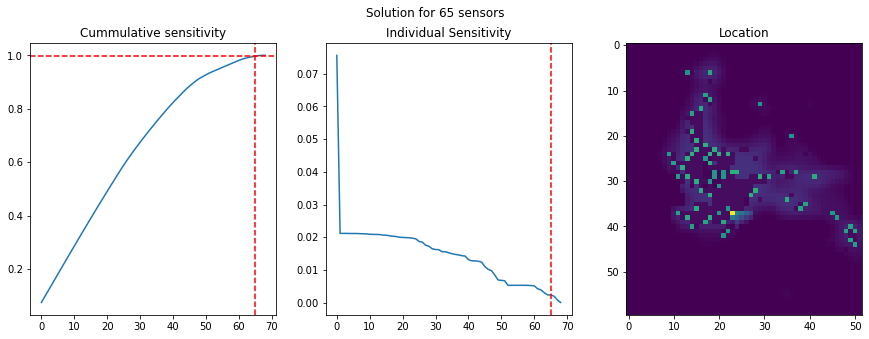

sensor: 66


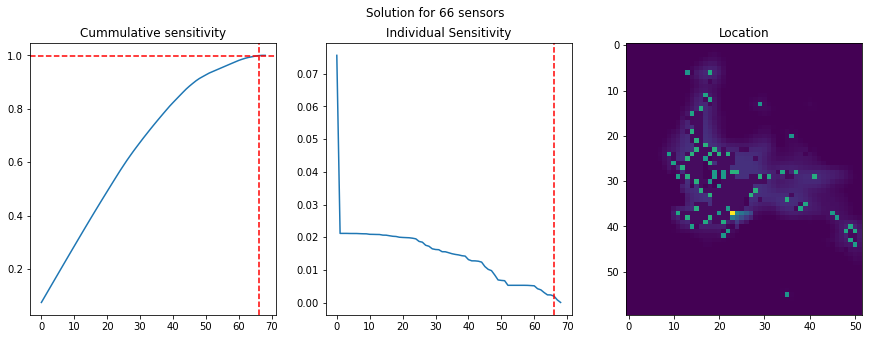

sensor: 67


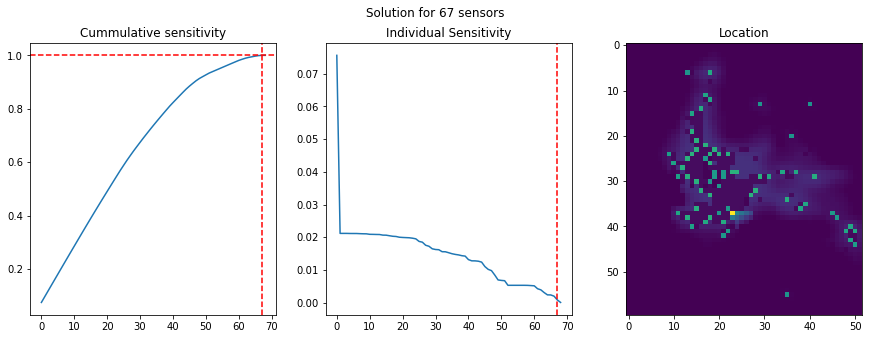

sensor: 68


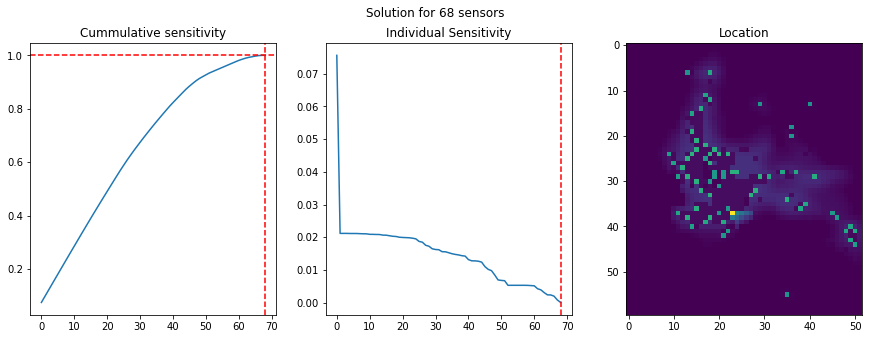

In [252]:
from matplotlib.pyplot import figure





for n in range(1,69):
    print("sensor:",n)
    p = cumsumSortedSensors[n]
    #figure(figsize=(5, 5), dpi=80)
    #plt.plot(cumsumSortedSensors)
    #plt.axhline(y = p, color = 'r', linestyle = '--')
    #plt.axvline(x = n, color = 'r', linestyle = '--')
    #plt.show()

    #figure(figsize=(5, 5), dpi=80)
    #plt.plot( sortedSensors)
    #plt.axvline(x = n, color = 'r', linestyle = '--')
    #plt.show()


    locationS = np.zeros(A.shape)

    for pos in L[:n]:
        locationS[pos[1]][pos[2]]=1

    #figure(figsize=(5, 5), dpi=80)
    #plt.imshow(locationS*np.max(W2)+W2)
    #plt.show()


  

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(15,5))
    fig.suptitle('Solution for '+str(n)+' sensors')
    ax1.plot(cumsumSortedSensors)
    ax1.title.set_text("Cummulative sensitivity")
    ax1.axhline(y = p, color = 'r', linestyle = '--')
    ax1.axvline(x = n, color = 'r', linestyle = '--')

    ax2.plot(sortedSensors)
    ax2.title.set_text("Individual Sensitivity")
    ax2.axvline(x = n, color = 'r', linestyle = '--')
    ax3.imshow(locationS*np.max(W2)+W2)
    ax3.title.set_text("Location")
    plt.show()

    fig.savefig('full_figure'+str(n)+'.png')

<Figure size 400x1200 with 0 Axes>

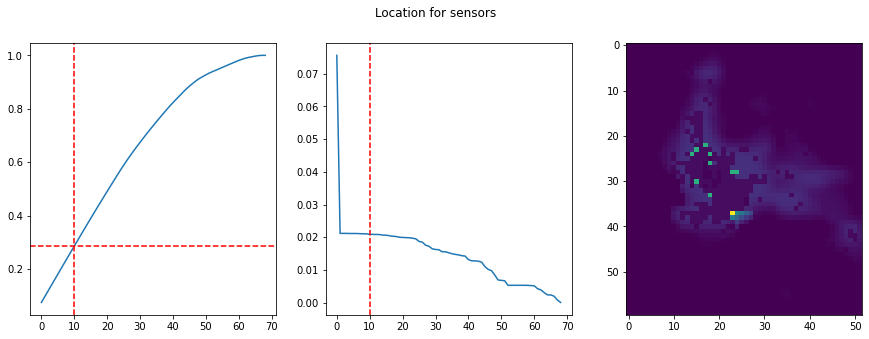

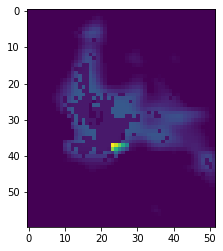

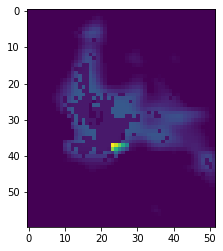

In [189]:
plt.imshow(W2)

**Referencias**

* https://grass.osgeo.org/grass76/manuals/r.neighbors.html

* https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html#sphx-glr-gallery-images-contours-and-fields-image-annotated-heatmap-py

Este es el 
* https://bookdown.org/markhoff/social_network_analysis/finding-groups-in-networks.html

* https://networkx.org/documentation/stable/reference/algorithms/component.html

Plática con Ivvan
* https://homepages.inf.ed.ac.uk/rbf/HIPR2/distance.htm
* https://answers.opencv.org/question/97681/better-ways-to-get-the-ridges-of-distance-transform-map/